In [58]:
import sagemaker

sess = sagemaker.Session()
bucket = sess.default_bucket()
prefix = 'sagemaker/deepar-redlight-violation' # change to your desired S3 prefix
region = sess.boto_region_name

role = sagemaker.get_execution_role()

In [59]:
import io
import json
import requests
import time
import sys
import matplotlib.pyplot as plt
import pandas as pd
!{sys.executable} -m pip install s3fs

Defaulting to user installation because normal site-packages is not writeable


In [60]:
import s3fs

In [61]:
datafile = 'Red_Light_Camera_Violations.csv'
red_light_violation_path = '{}/{}/{}.csv'.format(bucket, prefix, datafile)
s3_output_path = '{}/{}/output'.format(bucket, prefix)
train_data_path = '{}/{}/train/train.json'.format(bucket, prefix)
test_data_path = '{}/{}/test/test.json'.format(bucket, prefix)
url = 'https://data.cityofchicago.org/api/views/spqx-js37/rows.csv?accessType=DOWNLOAD'
# get the data from City of Chicago site
r = requests.get(url, allow_redirects=True)
open(datafile, 'wb').write(r.content)
  
# read the input file, and display sample rows/columns
pd.set_option('display.max_columns', 500)     
pd.set_option('display.max_rows', 50)    
df = pd.read_csv(open(datafile, 'rb'), encoding='utf-8')

# print first 10 lines to look at part of the dataset
df[['ADDRESS', 'VIOLATION DATE', 'VIOLATIONS']][0:10]

,ADDRESS,VIOLATION DATE,VIOLATIONS
0,4700 W IRVING PARK ROA,04/09/2015,4
1,2400 W VAN BUREN STREE,04/14/2015,5
2,11500 S HALSTED STREE,04/08/2015,5
3,4700 W IRVING PARK ROA,04/19/2015,4
4,3700 W IRVING PARK ROA,04/23/2015,3
5,2800 W 31ST,09/14/2014,3
6,2800 W 31ST,12/16/2014,1
7,4700 S WESTERN AVENUE,06/05/2019,3
8,2800 W 31ST,01/30/2015,4
9,6400 N WESTERN AVENUE,06/05/2019,2


In [62]:
df['drop_idx'] = df['ADDRESS']+df['VIOLATION DATE']
df.drop_duplicates('drop_idx', keep ='first', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 554824 entries, 0 to 624912
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   INTERSECTION    554824 non-null  object 
 1   CAMERA ID       554701 non-null  float64
 2   ADDRESS         554824 non-null  object 
 3   VIOLATION DATE  554824 non-null  object 
 4   VIOLATIONS      554824 non-null  int64  
 5   X COORDINATE    527873 non-null  float64
 6   Y COORDINATE    527873 non-null  float64
 7   LATITUDE        527873 non-null  float64
 8   LONGITUDE       527873 non-null  float64
 9   LOCATION        527873 non-null  object 
 10  drop_idx        554824 non-null  object 
dtypes: float64(5), int64(1), object(5)
memory usage: 50.8+ MB


In [63]:
df.drop(columns='drop_idx', inplace=True)
df['VIOLATION_DT'] = pd.to_datetime(df['VIOLATION DATE'])
df[['ADDRESS', 'VIOLATION_DT', 'VIOLATIONS']]
unique_addresses = df.ADDRESS.unique()
idx = pd.date_range(df.VIOLATION_DT.min(), df.VIOLATION_DT.max())
number_of_addresses = len(unique_addresses)
print('Unique Addresses {}'.format(number_of_addresses))
print('Minimum violation date is {}, maximum violation date is {}'.format(df.VIOLATION_DT.min(), df.VIOLATION_DT.max()))

Unique Addresses 316
Minimum violation date is 2014-07-01 00:00:00, maximum violation date is 2020-12-31 00:00:00


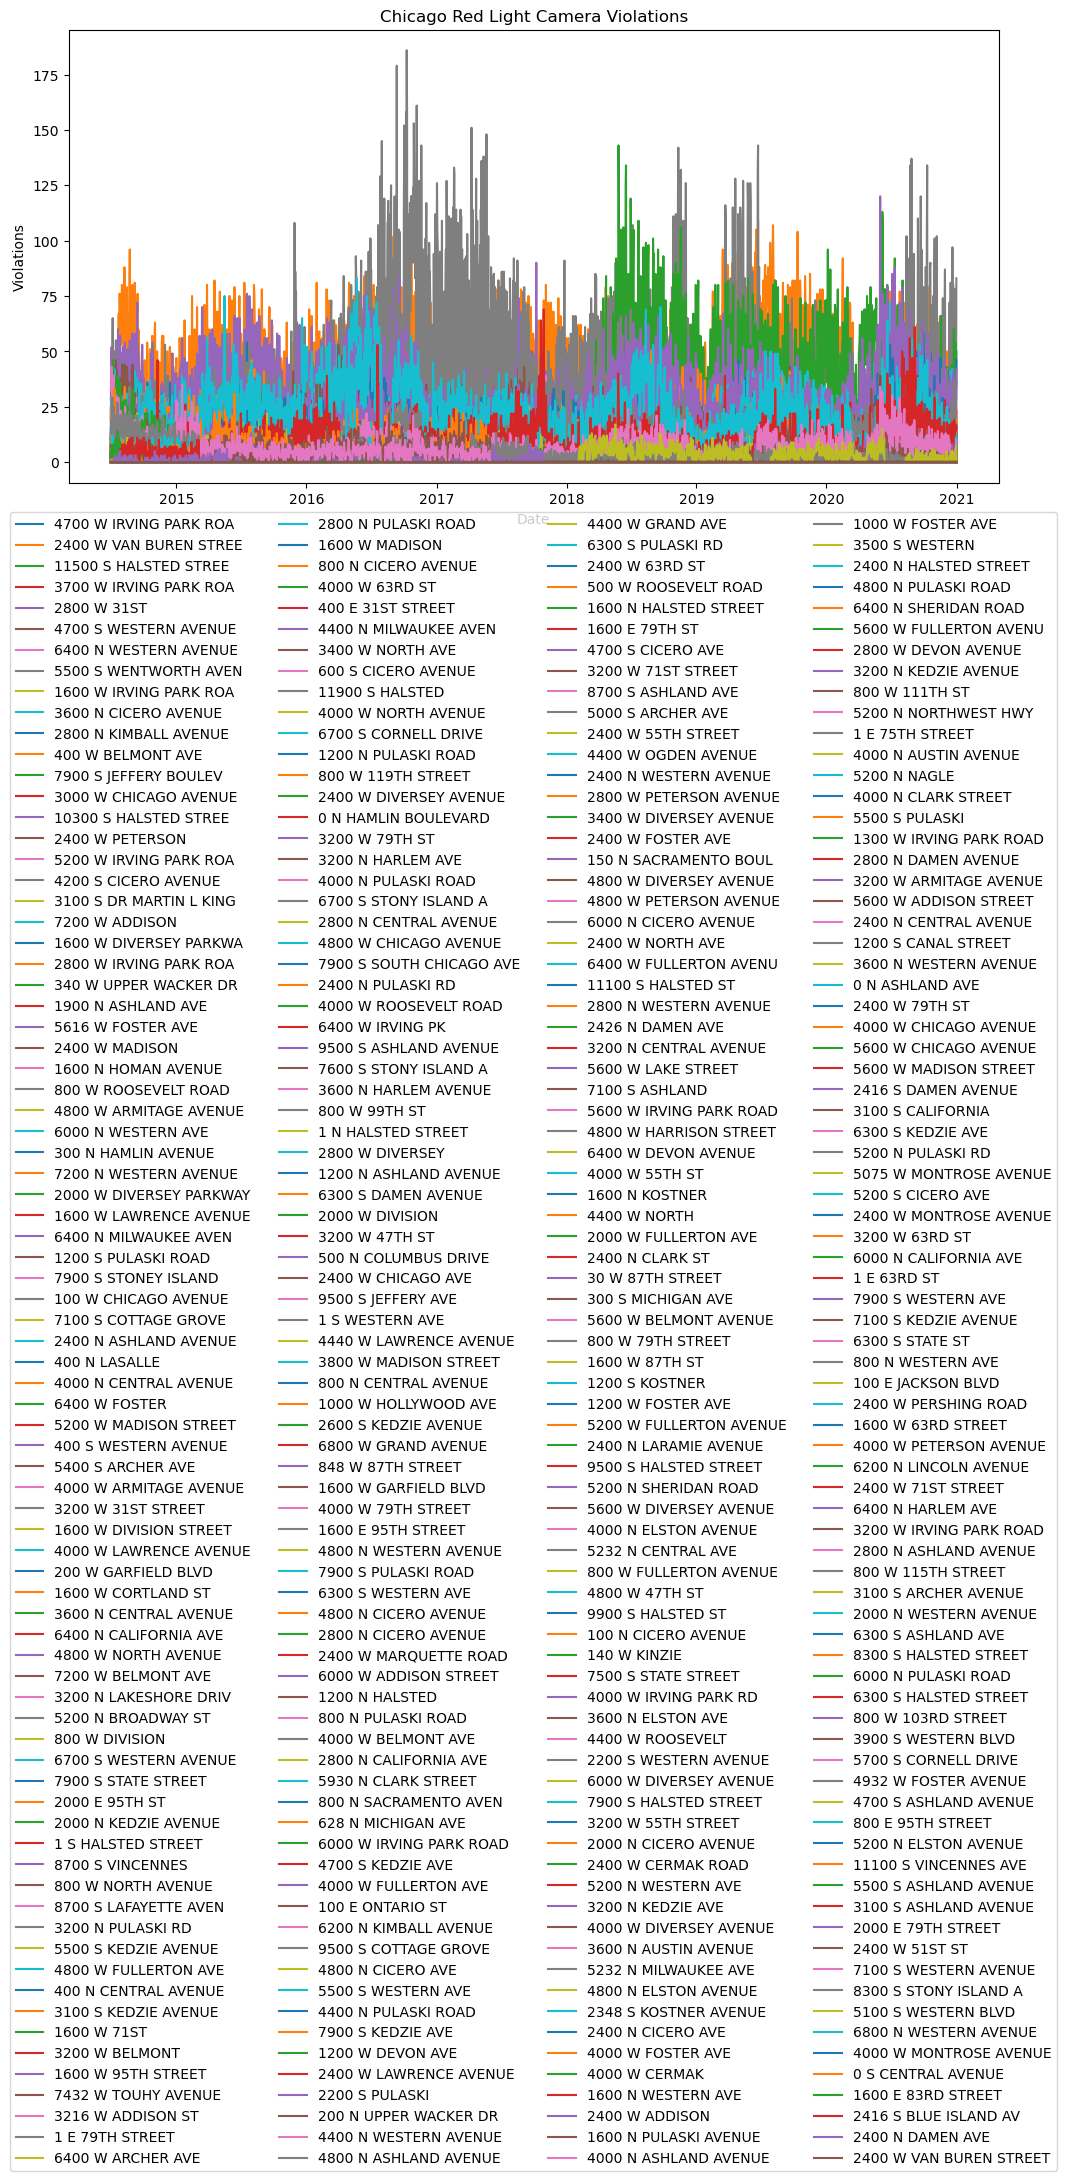

In [64]:
violation_list = []
for key in unique_addresses:
    temp_df = df[['VIOLATION_DT', 'VIOLATIONS']][df.ADDRESS == key]
    temp_df.set_index(['VIOLATION_DT'], inplace=True)
    temp_df.index = pd.DatetimeIndex(temp_df.index)
    temp_df = temp_df.reindex(idx, fill_value=0)
    violation_list.append(temp_df['VIOLATIONS'])

plt.figure(figsize=(12,6), dpi=100, facecolor='w')
for key, address in enumerate(unique_addresses):
    plt.plot(violation_list[key], label=address)

plt.ylabel('Violations')
plt.xlabel('Date')
plt.title('Chicago Red Light Camera Violations')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=False, ncol=4)
plt.show()

In [65]:
prediction_length = 60
# split data for training and testing
training = []
for i in violation_list:
    training.append(i[:-prediction_length])

In [66]:
def series_2_obj(series, cat=None):
    obj = {'start': str(series.index[0]), 'target': list(series)}
    if cat:
        obj['cat'] = cat
    return obj

def series_2_json(series, cat=None):
    return json.dumps(series_2_obj(series, cat))

In [67]:
encoding = 'utf-8'
s3filesystem = s3fs.S3FileSystem()
with s3filesystem.open(train_data_path, 'wb') as fp:
    for series in training:
        fp.write(series_2_json(series).encode(encoding))
        fp.write('\n'.encode(encoding))

with s3filesystem.open(test_data_path, 'wb') as fp:
    for series in violation_list:
        fp.write(series_2_json(series).encode(encoding))
        fp.write('\n'.encode(encoding))

In [68]:
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(region_name=region,
                          repo_name='forecasting-deepar')
Model = sagemaker.estimator.Estimator(container,
                                       role,
                                       train_instance_count=1,
                                       train_instance_type='ml.m4.xlarge',
                                       train_use_spot_instances=True, # use spot instances
                                       train_max_run=3600, # max training time in seconds
                                       train_max_wait=3600, # seconds to wait for spot instance
                                       output_path='s3://{}/{}'.format(bucket, s3_output_path),
                                       sagemaker_session=sess)
freq = 'D'
context_length = 60

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_max_run has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_use_spot_instances has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_max_wait has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [69]:
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.amazon.amazon_estimator import get_image_uri
Model.set_hyperparameters(time_freq=freq,
                           context_length=str(context_length),
                           prediction_length=str(prediction_length))

hyperparameter_ranges = {'mini_batch_size': IntegerParameter(100, 400),
                         'epochs': IntegerParameter(200, 400),
                         'num_cells': IntegerParameter(30,100),
                         'likelihood': CategoricalParameter(['negative-binomial', 'student-T','gaussian']),
                         'learning_rate': ContinuousParameter(0.0001, 0.1)}

objective_metric_name = 'test:RMSE'

In [70]:

Tunning = HyperparameterTuner(Model,
                              objective_metric_name,
                              hyperparameter_ranges,
                              max_jobs=10,
                              strategy='Bayesian',
                              objective_type='Minimize',
                              max_parallel_jobs=10,
                              early_stopping_type='Auto')

In [71]:
Input_Train = sagemaker.inputs.TrainingInput(s3_data='s3://{}/{}/train/'.format(bucket, prefix),
                                    content_type='json')
Input_Test = sagemaker.inputs.TrainingInput(s3_data='s3://{}/{}/test/'.format(bucket, prefix),
                                   content_type='json')

In [72]:
Tunning.fit({'train': Input_Train, 'test': Input_Test}, include_cls_metadata=False)
Tunning.wait()

.........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!
!


In [74]:
deepar_best_model = Tunning.best_training_job()
endpoint_name = Tunning.deploy(initial_instance_count=1,
                             endpoint_name=deepar_best_model,
                             instance_type='ml.m4.xlarge',
                             wait=True)


2021-01-14 19:34:08 Starting - Preparing the instances for training
2021-01-14 19:34:08 Downloading - Downloading input data
2021-01-14 19:34:08 Training - Training image download completed. Training in progress.
2021-01-14 19:34:08 Uploading - Uploading generated training model
2021-01-14 19:34:08 Completed - Training job completed
---------------!

In [152]:
class DeepARPredictor(sagemaker.predictor.RealTimePredictor):
    def set_prediction_parameters(self, freq, prediction_length):
        self.freq = freq
        self.prediction_length = prediction_length
    def predict(self, series, cat=None, encoding='utf-8', num_samples=100, quantiles=['0.1', '0.5', '0.9']):
        prediction_times = [x.index[-1] + x.index.freq for x in series]
        req = self.__encode_request(series, cat, encoding, num_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req)
        return self.__decode_response(res, prediction_times, encoding)
    def __encode_request(self, series, cat, encoding, num_samples, quantiles):
        instances = [series_2_obj(series[k], cat[k] if cat else None) for k in range(len(series))]
        configuration = {'num_samples': num_samples, 'output_types': ['quantiles'], 'quantiles': quantiles}
        http_request_data = {'instances': instances, 'configuration': configuration}
        return json.dumps(http_request_data).encode(encoding)
    def __decode_response(self, response, prediction_times, encoding):
        response_data = json.loads(response.decode(encoding))
        list_of_df = []
        for k in range(len(prediction_times)):
            prediction_index = pd.date_range(start=prediction_times[k], freq=self.freq, periods=self.prediction_length)
            list_of_df.append(pd.DataFrame(data=response_data['predictions'][k]['quantiles'], index=prediction_index))
        return list_of_df


In [153]:
from sagemaker.predictor import json_serializer
from sagemaker.serializers import IdentitySerializer
predictor = DeepARPredictor(endpoint_name = deepar_best_model,
                            sagemaker_session=sess,
                            serializer=IdentitySerializer(content_type="application/json"))

The class RealTimePredictor has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


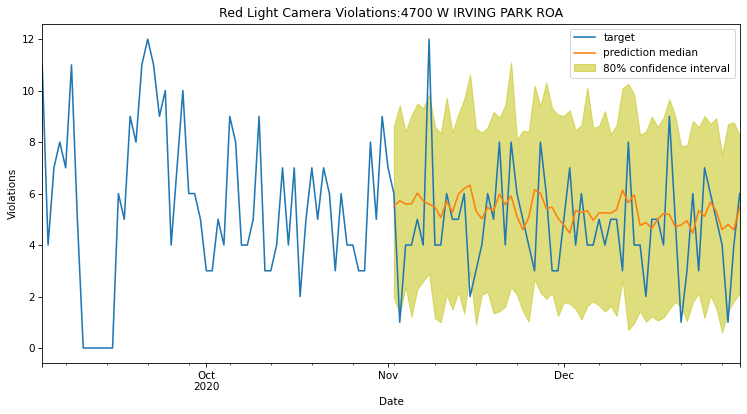

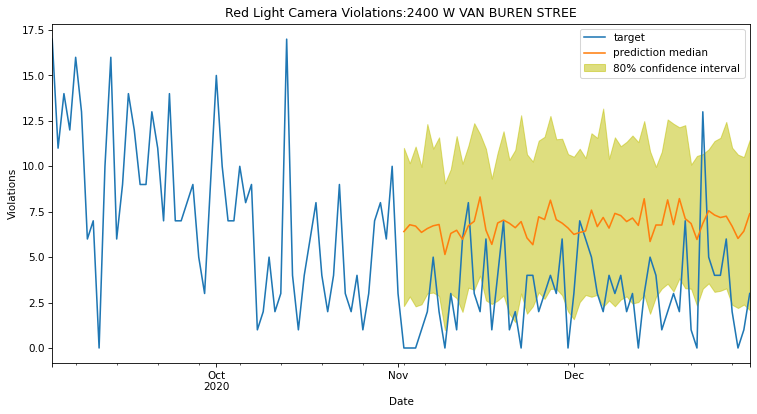

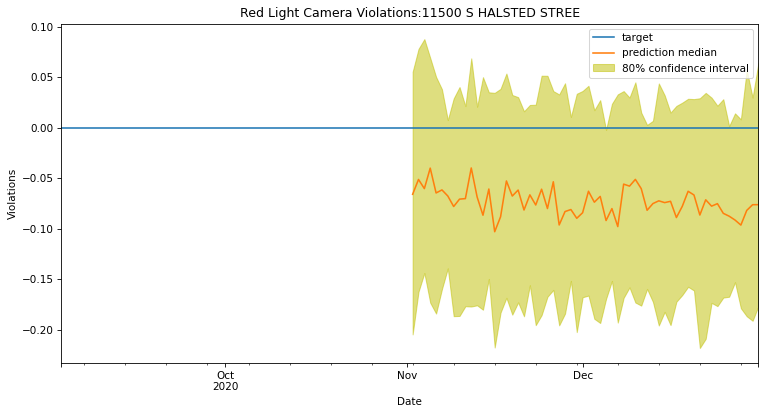

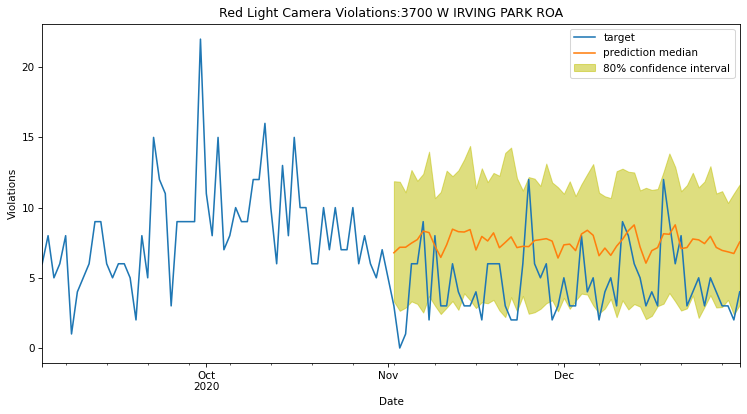

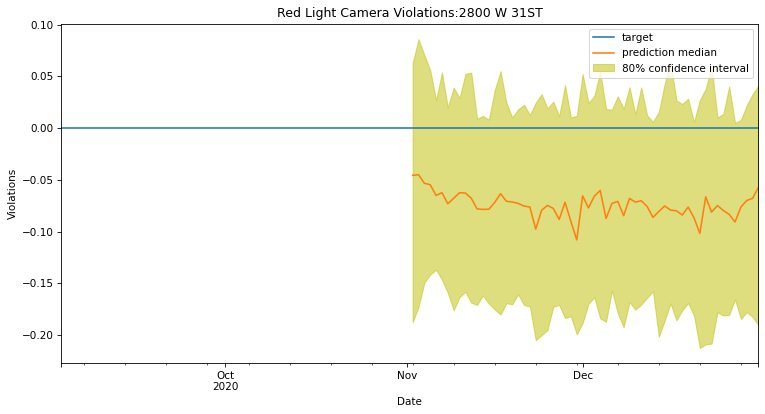

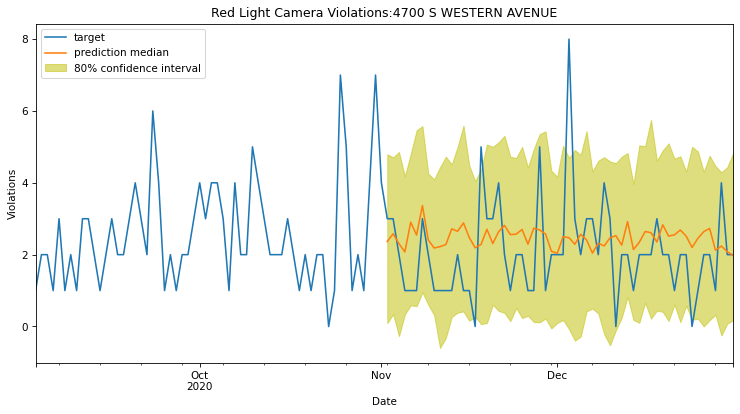

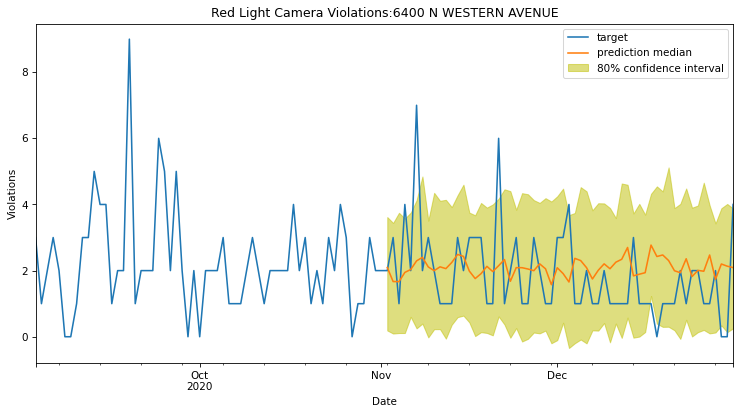

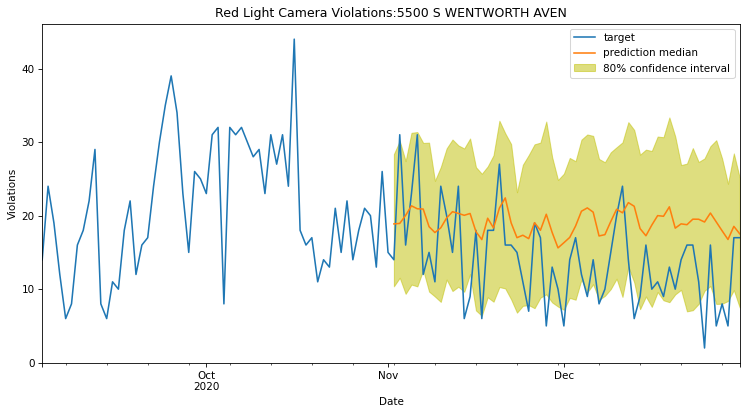

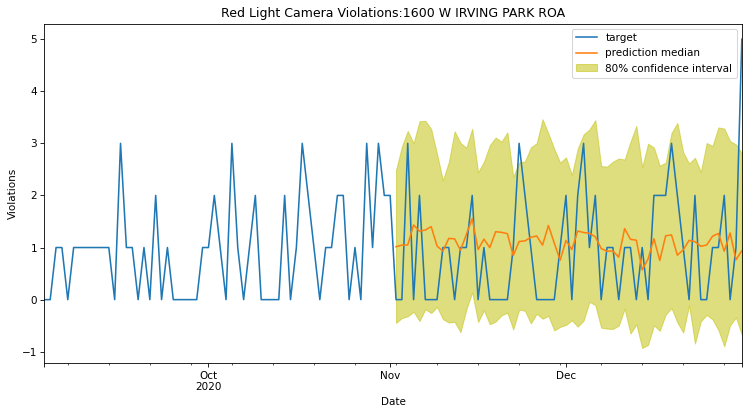

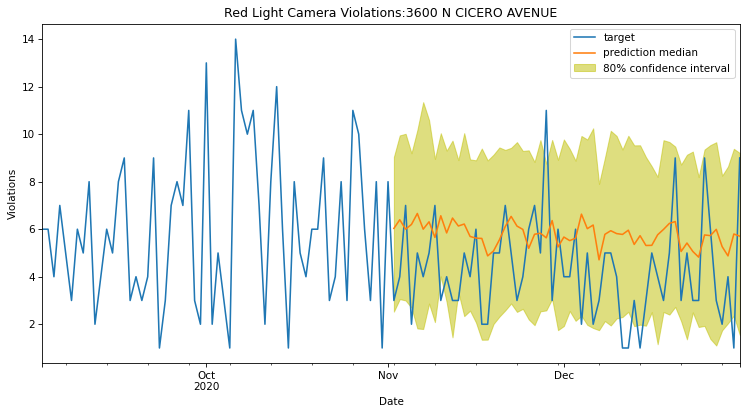

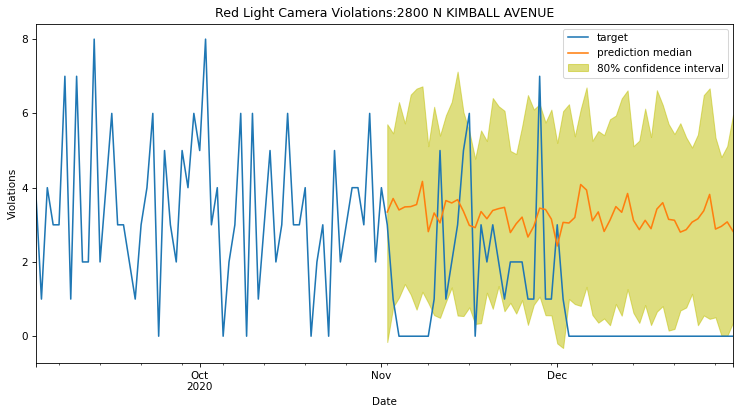

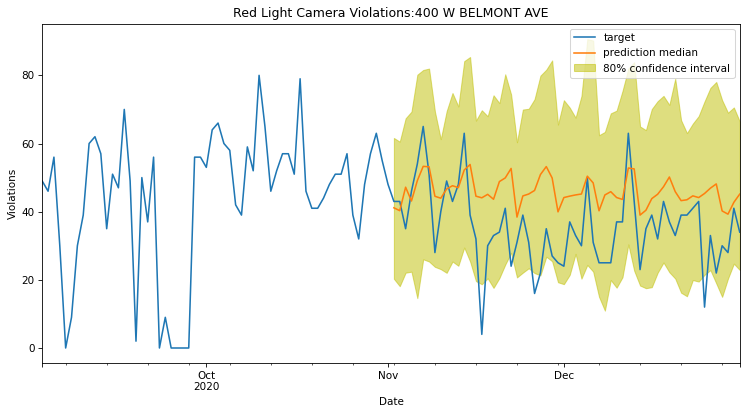

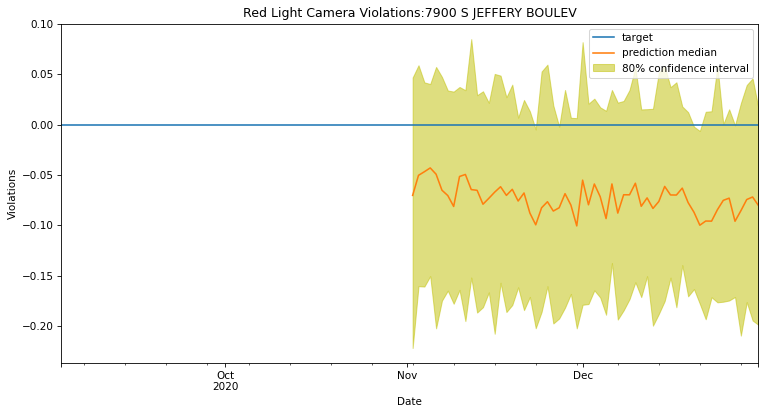

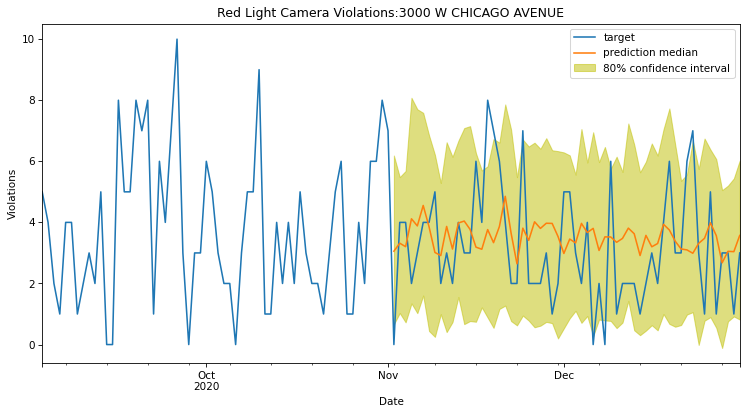

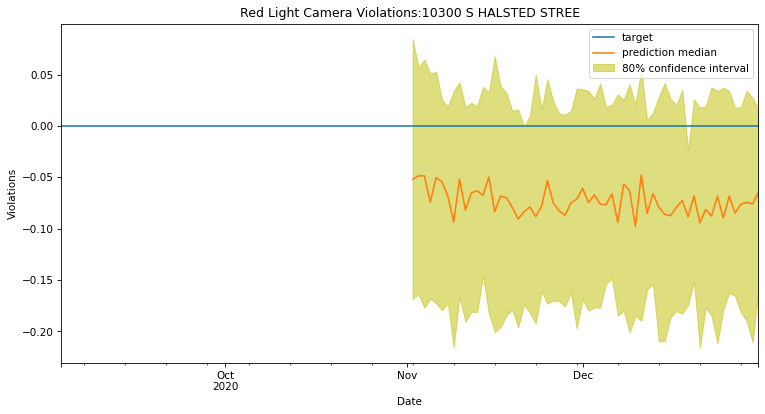

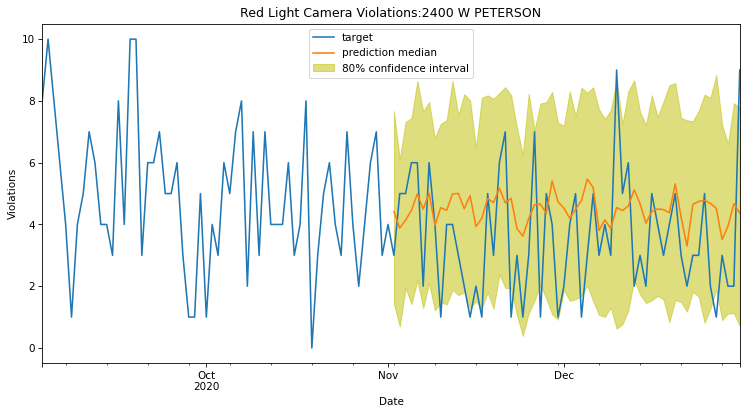

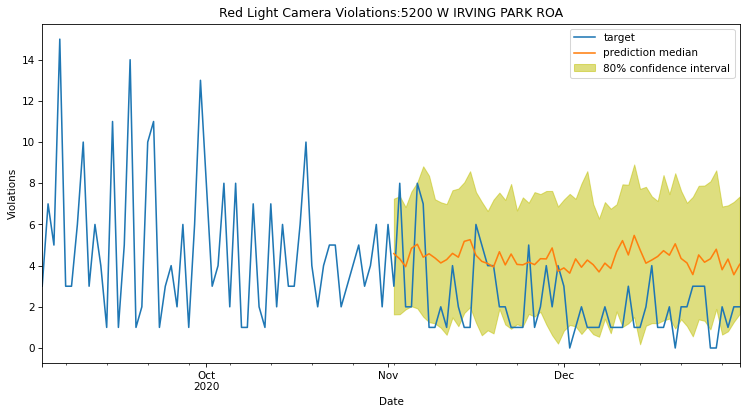

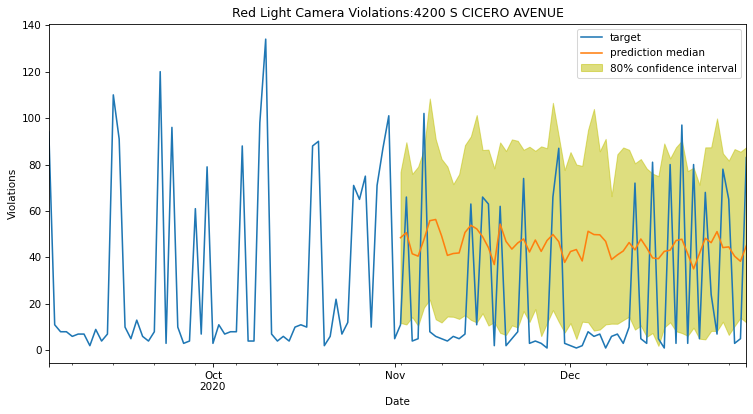

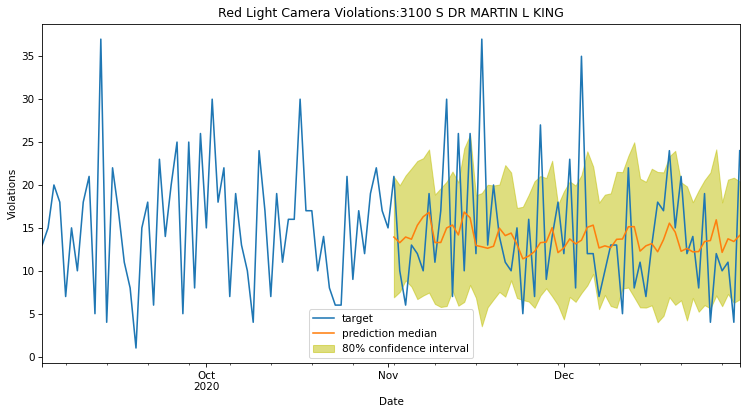

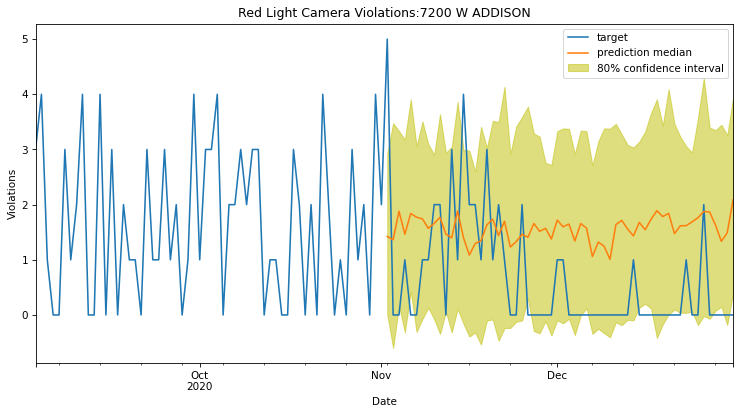

In [157]:
predictor.set_prediction_parameters(freq, prediction_length)
list_of_df = predictor.predict(training[:20])
actual_data = violation_list[:20]
for k in range(len(list_of_df)):
    plt.figure(figsize=(12,6), dpi=75, facecolor='w')
    plt.ylabel('Violations')
    plt.xlabel('Date')
    plt.title('Red Light Camera Violations:' + unique_addresses[k])
    actual_data[k][-prediction_length-context_length:].plot(label='target')
    p10 = list_of_df[k]['0.1']
    p90 = list_of_df[k]['0.9']
    plt.fill_between(p10.index, p10, p90, color='y', alpha=0.5,label='80% confidence interval')
    list_of_df[k]['0.5'].plot(label='prediction median')
    plt.legend()
    plt.show()

In [158]:
predictor.delete_endpoint(endpoint_name)